### Required libraries

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sys
import numpy as np
import os.path as op
from os import mkdir, makedirs
import scipy.stats as stats
import nipype.interfaces.fsl as fsl
from subprocess import call, Popen, check_output, PIPE
import nibabel as nib
from shutil import copyfile, rmtree
import pandas as pd
import scipy.io as sio
from sklearn import cross_validation
from sklearn import linear_model
from __future__ import division
from numpy.polynomial.legendre import Legendre
import shlex
from scipy import signal
import gzip

### Utils

In [37]:
def plot_hist(score,title,xlabel):
    h,b = np.histogram(score, bins='auto')
    plt.hist(score,bins=b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    return h

### Parameters

In [10]:
behavFile = 'unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
release = 'Q2'
outScore = 'PMAT24_A_CR'
DATADIR = '/media/paola/HCP/'
PARCELDIR = '/home/paola/parcellations'
parcellation = 'shenetal_neuroimage2013'
overwrite = False
thisRun = 'rfMRI_REST1'
isDataClean = True
doPlot = True
useLegendre = True
nPoly = 4
queue = False
useFeat = False
preproOnly = True
doTsmooth = True
normalize = 'zscore'

if thisRun == 'rfMRI_REST1':
    outMat = 'rest_1_mat'
elif thisRun == 'rfMRI_REST2':
    outMat = 'rest_1_mat'
else:
    sys.exit("Invalid run code")  
    
suffix = '_hp2000_clean' if isDataClean else ''   

def buildpath(subject,fmriRun):
    return op.join(DATADIR, subject,'MNINonLinear','Results',fmriRun)

def testpath(subject,fmriRun):
    return op.join(DATADIR, 'Testing', subject,'Results',fmriRun)

### Functions

In [13]:
def makeTissueMasks(subject,fmriRun,overwrite):
    fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+suffix+'.nii.gz')
    WMmaskFileout = op.join(buildpath(subject,fmriRun), 'WMmask.nii')
    CSFmaskFileout = op.join(buildpath(subject,fmriRun), 'CSFmask.nii')
    GMmaskFileout = op.join(buildpath(subject,fmriRun), 'GMmask.nii')
    WMCSFmaskFileout = op.join(buildpath(subject,fmriRun), 'WMCSFmask.nii')
    WMCSFGMmaskFileout = op.join(buildpath(subject,fmriRun), 'WMCSFGMmask.nii')
    
    if not op.isfile(WMCSFGMmaskFileout) or overwrite:
        # load ribbon.nii.gz and wmparc.nii.gz
        ribbonFilein = op.join(DATADIR, subject, 'MNINonLinear','ribbon.nii.gz')
        wmparcFilein = op.join(DATADIR, subject, 'MNINonLinear', 'wmparc.nii.gz')
        # make sure it is resampled to the same space as the functional run
        ribbonFileout = op.join(buildpath(subject,fmriRun), 'ribbon.nii.gz')
        wmparcFileout = op.join(buildpath(subject,fmriRun), 'wmparc.nii.gz')
        # make identity matrix to feed to flirt for resampling
        with open('eye.mat','w') as fid:
            fid.write('1 0 0 0\n0 1 0 0\n0 0 1 0\n0 0 0 1')
        
        flirt_ribbon = fsl.FLIRT(in_file=ribbonFilein, out_file=ribbonFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_ribbon.run()

        flirt_wmparc = fsl.FLIRT(in_file=wmparcFilein, out_file=wmparcFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_wmparc.run()
        
        # load nii (ribbon & wmparc)
        ribbon = nib.load(ribbonFileout).get_data()
        wmparc = nib.load(wmparcFileout).get_data()
        
        # white & CSF matter mask
        # indices are from FreeSurferColorLUT.txt
        
        # Left-Cerebral-White-Matter, Right-Cerebral-White-Matter
        ribbonWMstructures = [2, 41]
        # Left-Cerebral-Cortex, Right-Cerebral-Cortex
        ribbonGMstrucures = [3, 42]
        # Cerebellar-White-Matter-Left, Brain-Stem, Cerebellar-White-Matter-Right
        wmparcWMstructures = [7, 16, 46]
        # Left-Cerebellar-Cortex, Right-Cerebellar-Cortex, Thalamus-Left, Caudate-Left
        # Putamen-Left, Pallidum-Left, Hippocampus-Left, Amygdala-Left, Accumbens-Left 
        # Diencephalon-Ventral-Left, Thalamus-Right, Caudate-Right, Putamen-Right
        # Pallidum-Right, Hippocampus-Right, Amygdala-Right, Accumbens-Right
        # Diencephalon-Ventral-Right
        wmparcGMstructures = [8, 47, 10, 11, 12, 13, 17, 18, 26, 28, 49, 50, 51, 52, 53, 54, 58, 60]
        # Fornix, CC-Posterior, CC-Mid-Posterior, CC-Central, CC-Mid-Anterior, CC-Anterior
        wmparcCCstructures = [250, 251, 252, 253, 254, 255]
        # Left-Lateral-Ventricle, Left-Inf-Lat-Vent, 3rd-Ventricle, 4th-Ventricle, CSF
        # Left-Choroid-Plexus, Right-Lateral-Ventricle, Right-Inf-Lat-Vent, Right-Choroid-Plexus
        wmparcCSFstructures = [4, 5, 14, 15, 24, 31, 43, 44, 63]
        
        # make masks
        WMmask = np.double(np.logical_and(np.logical_and(np.logical_or(np.logical_or(np.in1d(ribbon, ribbonWMstructures),
                                                                              np.in1d(wmparc, wmparcWMstructures)),
                                                                np.in1d(wmparc, wmparcCCstructures)),
                                                  np.logical_not(np.in1d(wmparc, wmparcCSFstructures))),
                                   np.logical_not(np.in1d(wmparc, wmparcGMstructures))))
        CSFmask = np.double(np.in1d(wmparc, wmparcCSFstructures))
        WMCSFmask = np.double((WMmask > 0) | (CSFmask > 0))
        GMmask = np.double(np.logical_or(np.in1d(ribbon,ribbonGMstrucures),np.in1d(wmparc,wmparcGMstructures)))
        WMCSFGMmask = np.double((WMmask > 0) | (CSFmask > 0) | (GMmask > 0))
        
        # write masks
        ref = nib.load(wmparcFileout)
        WMmask = np.reshape(WMmask,ref.shape)
        img = nib.Nifti1Image(WMmask, ref.affine)
        nib.save(img, WMmaskFileout)
        
        CSFmask = np.reshape(CSFmask,ref.shape)
        img = nib.Nifti1Image(CSFmask, ref.affine)
        nib.save(img, CSFmaskFileout)
        
        GMmask = np.reshape(GMmask,ref.shape)
        img = nib.Nifti1Image(GMmask, ref.affine)
        nib.save(img, GMmaskFileout)
        
        WMCSFmask = np.reshape(WMCSFmask,ref.shape)
        img = nib.Nifti1Image(WMCSFmask, ref.affine)
        nib.save(img, WMCSFmaskFileout)
        
        WMCSFGMmask = np.reshape(WMCSFGMmask,ref.shape)
        img = nib.Nifti1Image(WMCSFGMmask, ref.affine)
        nib.save(img, WMCSFGMmaskFileout)

In [14]:
subject = op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))
print subject
fmriRun = op.basename(op.dirname(fmriFile))
print fmriRun
makeTissueMasks(subject,fmriRun,True)

734045
rfMRI_REST1_LR


In [11]:
fmriFile = '/media/paola/HCP/734045/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz'

In [3]:
fmriFile = '/media/paola/HCP/rfMRI_REST1_LR_hp2000_clean.nii'

In [278]:
op.join(buildpath(subject,fmriRun))

'/media/paola/HCP/992774/MNINonLinear/Results/rfMRI_REST1_RL'

In [4]:
img = nib.load(fmriFile)

In [7]:
print img.header.sizeof_hdr, img.header.get_data_offset()

348 0


In [44]:
def Finn_preprocess(subject,fmriRun,isCifti):
    
    if isCifti:
        fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.dtseries.nii')
        outFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'_FinnPrepro.dtseries.nii')
        prefix = 'GrayOrdStep'
    else:
        fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.nii.gz')
        outFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'_FinnPrepro.nii.gz')
        prefix = 'VolumeStep'
        
    if not op.isfile(outFile):
        
        WMCSFmaskFile = op.join(buildpath(subject,fmriRun),'WMCSFmask.nii')
        WMmaskFile = op.join(buildpath(subject,fmriRun),'WMmask.nii')
        CSFmaskFile = op.join(buildpath(subject,fmriRun),'CSFmask.nii')
        GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii')
        WMCSFGMmaskFile = op.join(buildpath(subject,fmriRun),'WMCSFGMmask.nii')
        
        # make WM, CSF, GM masks (if not already done)
        if not op.isfile(WMCSFGMmaskFile):
            makeTissueMasks(subject,fmriRun,overwrite)
        
        # get some info
        if isCifti:
            cmd = 'cut -d \' \' -f 4 <<< $(wb_command -file-information {} -no-map-info|grep "Number of Columns")'.format(fmriFile)
            nTRs = long(check_output(cmd,shell=True))
            # retrieve TR
            cmd = 'cut -d \' \' -f 4 <<< $(wb_command -file-information {} -no-map-info|grep "Map Interval Step")'.format(fmriFile)
            TR = double(check_output(cmd,shell=True))
            fmriFileOrig = fmriFile;
            fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'fake.nii.gz')
            cmd = 'wb_command -cifti-convert -to-nifti {} {}'.format(fmriFileOrig,fmriFile)
            call(cmd,shell=True)
            img = nib.load(fmriFile)
            hdr = img.header.structarr
            # retrieve dimensions
            dim1 = long(hdr['dim'][1])
            dim2 = long(hdr['dim'][2])
            dim3 = long(hdr['dim'][3])
        else:
            img = nib.load(fmriFile)
            hdr = img.header.structarr
            nTRs = long(hdr['dim'][4])
            # retrieve TR
            TR = hdr['pixdim'][4]
            # retrieve dimensions
            dim1 = long(hdr['dim'][1])
            dim2 = long(hdr['dim'][2])
            dim3 = long(hdr['dim'][3])
            
        ## DO PREPROCESSING:
        ## 1) Regress temporal drift from CSF and white matter (3rd order Legendre polynomial)
        print 'Step 1 (detrend WMCSF voxels, polynomial order 3)'
        # ** a) create polynomial regressor **
        order = 3
        x = np.arange(nTRs)
        x = x - x.max()/2
        num_pol = range(nPoly+1)
        y = np.ones((len(num_pol),len(x)))   
        coeff = [(1,0,0,0),(0,1,0,0),(0,0,1,0),(0,0,0,1)]
        # Print out text file for each polynomial to be used as a regressor
        for i in num_pol:
            myleg = Legendre(coeff[i])
            y[i,:] = myleg(x) 
            if i>0:
                y[i,:] = y[i,:] - np.mean(y[i,:])
                y[i,:] = y[i,:]/np.max(y[i,:])
            np.savetxt(op.join(buildpath(subject,fmriRun),
                               'poly_detrend_legendre' + str(i) + '.txt'), y[i,:] ,fmt='%.2f')
        
        # ** b) use feat to regress it out
        # keep only WM/CSF voxels to speed things up
        if isCifti:
            volFile = fmriFileOrig.replace('_Atlas.dtseries.nii','.nii.gz')
        else:
            volFile = fmriFile
        inFile = op.join(buildpath(subject,fmriRun),fmriRun+'_WMCSF.nii')
        if not op.isfile(inFile):
            mymask1 = fsl.maths.ApplyMask(in_file=volFile, mask_file=WMCSFmaskFile, \
                                              out_file=inFile)
            mymask1.run()
            
        step1_outFile = op.join(buildpath(subject,fmriRun),'Step1.nii')
        if not op.isfile(step1_outFile):
            if useFeat:
                # copy and alter detrendpoly1+2+3.fsf
                fsfFile = op.join(buildpath(subject,fmriRun), 'Step1.fsf')
                copyfile(op.join(DATADIR,'detrendpoly1+2+3.fsf'), fsfFile)
                cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
                    .format(op.join(buildpath(subject,fmriRun),'step1.feat'),fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
                    .format(TR,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
                    .format(nTRs,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
                    .format(dim1*dim2*dim3*nTRs,fsfFile)
                call(cmd,shell=True) 
                cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
                    .format(inFile,fsfFile)
                call(cmd,shell=True)
                for i in range(order):
                    cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                        .format(i+1,i+1,op.join(buildpath(subject,fmriRun),
                                                'poly_detrend_legendre{}.txt'.format(i+1)),fsfFile)
                    call(cmd,shell=True)

                # run feat
                myfeat1 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
                myfeat1.run()
                
                res4d = op.join(buildpath(subject,fmriRun),'Step1.feat','stats','res4d.nii.gz')
                mask = op.join(buildpath(subject,fmriRun),'Step1.feat','stats','mean_func.nii.gz')
                mymaths1 = fsl.maths.MathsCommand(in_file=res4d, out_file=step1_outFile,
                                                 args='-add 1 -mask '+mask)
                mymaths1.run()
            else:
                img = nib.load(inFile)
                nib.save(img,step1_outFile)
                data = np.memmap(step1_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                X  = np.concatenate((np.ones([nTRs,1]), y[1:4,:].T), axis=1)
                
                for i in range(nRows):
                    for j in range(nCols):
                        for k in range(nSlices):
                            fit = np.linalg.lstsq(X, np.squeeze(data[i,j,k,:])[:,np.newaxis])[0]
                            fittedvalues = np.dot(X, fit)
                            resid = data[i,j,k,:] - np.ravel(fittedvalues)
                            data[i,j,k,:] = resid
                del data
            
        
        ## 2. Regress CSF/WM signal from gray matter voxels
        print 'Step 2 (regress WMCSF signal from GM (two separate means))'
        # ** a) extract the WM and the CSF data from the detrended volume
        WMtxtFileout = op.join(buildpath(subject,fmriRun),'Step1WM.txt')
        if not op.isfile(WMtxtFileout):
            meantsWM = fsl.ImageMeants(in_file=step1_outFile, out_file=WMtxtFileout, mask=WMmaskFile)
            meantsWM.run()
            
        CSFtxtFileout = op.join(buildpath(subject,fmriRun),'Step1CSF.txt')
        if not op.isfile(CSFtxtFileout):
            meantsCSF = fsl.ImageMeants(in_file=step1_outFile, out_file=CSFtxtFileout, mask=CSFmaskFile)
            meantsCSF.run()    
        
        # ** b) keep only GM voxels to speed things up
        if isCifti:
            inFile = fmriFile
        else:
            inFile = op.join(buildpath(subject,fmriRun),fmriRun+'_GM.nii')
            if not op.isfile(inFile):
                mymask2 = fsl.maths.ApplyMask(in_file=fmriFile, mask_file=GMmaskFile, \
                                                  out_file=inFile)
                mymask2.run()
        
        step2_outFile = op.join(buildpath(subject,fmriRun), prefix+'2.nii')
        if not op.isfile(step2_outFile):
            if useFeat: 
                # ** c) use feat to regress them out **
                # copy and alter regressWM+CSF.fsf
                fsfFile = op.join(buildpath(subject,fmriRun), prefix+'2.fsf')
                copyfile(op.join(DATADIR,'regressWM+CSF.fsf'), fsfFile)
                cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
                    .format(op.join(buildpath(subject,fmriRun),prefix+'2.feat'),fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
                    .format(TR,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
                    .format(nTRs,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
                    .format(dim1*dim2*dim3*nTRs,fsfFile)
                call(cmd,shell=True) 
                cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
                    .format(inFile,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(custom1) /c\\set fmri(custom1) "{}"\' {}'\
                    .format(WMtxtFileout,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(custom2) /c\\set fmri(custom2) "{}"\' {}'\
                    .format(CSFtxtFileout,fsfFile)
                call(cmd,shell=True)        
                # run feat
                myfeat2 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
                myfeat2.run()    
                res4d = op.join(buildpath(subject,fmriRun),prefix+'2.feat','stats','res4d.nii.gz')
                mask = op.join(buildpath(subject,fmriRun),prefix+'2.feat','stats','mean_func.nii.gz')
                mymaths2 = fsl.maths.MathsCommand(in_file=res4d, out_file=step2_outFile,
                                                 args='-add 1 -mask '+mask)
                mymaths2.run()
            else:
                img = nib.load(inFile)
                nib.save(img,step2_outFile)
                data = np.memmap(step2_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                X  = np.concatenate((np.ones([nTRs,1]),
                                     np.loadtxt(WMtxtFileout)[:,np.newaxis],
                                     np.loadtxt(CSFtxtFileout)[:,np.newaxis]), 
                                    axis=1)
                for i in range(nRows):
                    for j in range(nCols):
                        for k in range(nSlices):
                            fit = np.linalg.lstsq(X, np.squeeze(data[i,j,k,:])[:,np.newaxis])[0]
                            fittedvalues = np.dot(X, fit)
                            resid = data[i,j,k,:] - np.ravel(fittedvalues)
                            data[i,j,k,:] = resid
                del data
        
        # add the results of steps 1 & 2 for input to the next stage
        step12_outFile = op.join(buildpath(subject,fmriRun),prefix+'1+2.nii')
        if not op.isfile(step12_outFile):
            myadd1 = fsl.maths.BinaryMaths(in_file=step1_outFile, operation='add',\
                                         operand_file=step2_outFile, out_file=step12_outFile)
            myadd1.run()
            
        ## 3. Regress motion parameters (found in the Movement_Regressors_dt_txt
        # file from HCP)    
        print 'Step 3 (regress 12 motion parameters from whole brain)'
        # ** a) load the detrended motion parameters
        motionFile = op.join(buildpath(subject,fmriRun),\
                            'Movement_Regressors_dt.txt')
        # this needs to be split into columns
        colNames = ['mmx','mmy','mmz','degx','degy','degz','dmmx','dmmy','dmmz','ddegx','ddegy','ddegz']
        df = pd.read_csv(motionFile,delim_whitespace=True,header=None)
        df.columns = colNames
        for iCol in range(len(colNames)):
            with open(motionFile.replace('.txt','_'+colNames[iCol]+'.txt'),'w') as tmp:
                df.to_csv(path_or_buf=tmp,sep='\n',columns=[colNames[iCol]],header=None,index=False)
                
        # ** b) use feat to regress them out **
        step3_outFile = op.join(buildpath(subject,fmriRun),prefix+'3.nii')
        if isCifti:
            inFile = step2_outFile
        else:
            inFile = step12_outFile
        if not op.isfile(step3_outFile):
            if useFeat:            
                # copy and alter regressM12.fsf
                fsfFile = op.join(buildpath(subject,fmriRun), prefix+'3.fsf')
                copyfile(op.join(DATADIR,'regressM12.fsf'), fsfFile)
                cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
                    .format(op.join(buildpath(subject,fmriRun),prefix+'3.feat'),fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
                    .format(TR,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
                    .format(nTRs,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
                    .format(dim1*dim2*dim3*nTRs,fsfFile)
                call(cmd,shell=True) 
                cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
                    .format(inFile,fsfFile)
                call(cmd,shell=True)
                for iCol in range(len(colNames)):
                    cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                        .format(iCol+1,iCol+1,motionFile.replace('.txt','_'+colNames[iCol]+'.txt'),fsfFile)
                    call(cmd,shell=True)   
                # run feat
                myfeat3 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
                myfeat3.run()
                res4d = op.join(buildpath(subject,fmriRun),prefix+'3.feat','stats','res4d.nii.gz')
                mask = op.join(buildpath(subject,fmriRun),prefix+'3.feat','stats','mean_func.nii.gz')
                mymaths3 = fsl.maths.MathsCommand(in_file=res4d, out_file=step3_outFile,
                                                 args='-add 1 -mask '+mask)
                mymaths3.run()
            else:
                img = nib.load(inFile)
                nib.save(img,step3_outFile)
                data = np.memmap(step3_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                X  = np.concatenate((np.ones([nTRs,1]),
                                     np.loadtxt(colNames[0])[:,np.newaxis]), axis=1)
                for iCol in range(1,len(colNames)):
                    X = np.concatenate((X,np.loadtxt(colNames[iCol])[:,np.newaxis]),axis=1)
                
                for i in range(nRows):
                    for j in range(nCols):
                        for k in range(nSlices):
                            fit = np.linalg.lstsq(X, np.squeeze(data[i,j,k,:])[:,np.newaxis])[0]
                            fittedvalues = np.dot(X, fit)
                            resid = data[i,j,k,:] - np.ravel(fittedvalues)
                            data[i,j,k,:] = resid
                del data
                

        ## 4. Temporal smoothing with Gaussian kernel (sigma = 1 TR)
        print 'Step 4 (temporal smoothing with Gaussian kernel)'
        step4_outFile = op.join(buildpath(subject,fmriRun),'4.nii')
        if not op.isfile(step4_outFile):
            myfilter = fsl.maths.TemporalFilter(in_file=step3_outFile,highpass_sigma=0, lowpass_sigma=1,\
                                               out_file=step4_outFile)
            myfilter.run()
            
        ## 5. Regress temporal drift from gray matter (3rd order polynomial)
        print ('Step 5 (detrend gray matter voxels, polynomial order 3)')
        # the polynomial regressors have already been created
        # we just have to regress them out, again using feat
        if isCifti:
            inFile = step4_outFile
        else:
            inFile = step4_outFile.replace('.nii.gz','_GM.nii')
            inFile2 = step4_outFile.replace('.nii.gz','_WMCSF.nii')
            if not op.isfile(inFile):
                mymask3 = fsl.maths.ApplyMask(in_file=step4_outFile, mask_file=GMmaskFile, \
                                                  out_file=inFile)
                mymask3.run()

            if not op.isfile(inFile2):
                mymask4 = fsl.maths.ApplyMask(in_file=step4_outFile, mask_file=WMCSFmaskFile, \
                                                  out_file=inFile2)
                mymask4.run()
        step5_outFile = op.join(buildpath(subject,fmriRun),prefix+'5.nii')
        if not op.isfile(step5_outFile):
            if useFeat:
                # ** b) use feat to regress them out **
                # copy and alter detrendpoly3.fsf
                fsfFile = op.join(buildpath(subject,fmriRun), prefix+'5.fsf')
                copyfile(op.join(DATADIR,'detrendpoly1+2+3.fsf'), fsfFile)
                cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
                    .format(op.join(buildpath(subject,fmriRun),prefix+'5.feat'),fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
                    .format(TR,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
                    .format(nTRs,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
                    .format(dim1*dim2*dim3*nTRs,fsfFile)
                call(cmd,shell=True) 
                cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
                    .format(inFile,fsfFile)
                call(cmd,shell=True)
                for i in range(order):
                    cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                        .format(i+1,i+1,op.join(buildpath(subject,fmriRun),'poly_detrend_legendre{}.txt'.format(i+1)),fsfFile)
                    call(cmd,shell=True)

                # run feat
                myfeat4 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
                myfeat4.run()
                res4d = op.join(buildpath(subject,fmriRun),prefix+'5.feat','stats','res4d.nii.gz')
                mask = op.join(buildpath(subject,fmriRun),prefix+'5.feat','stats','mean_func.nii.gz')
                mymaths4 = fsl.maths.MathsCommand(in_file=res4d, out_file=step5_outFile,
                                                 args='-add 1 -mask '+mask)
                mymaths4.run()
            else:
                img = nib.load(inFile)
                nib.save(img,step5_outFile)
                data = np.memmap(step5_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                X  = np.concatenate((np.ones([nTRs,1]), y[1:4,:].T), axis=1)
                
                for i in range(nRows):
                    for j in range(nCols):
                        for k in range(nSlices):
                            fit = np.linalg.lstsq(X, np.squeeze(data[i,j,k,:])[:,np.newaxis])[0]
                            fittedvalues = np.dot(X, fit)
                            resid = data[i,j,k,:] - np.ravel(fittedvalues)
                            data[i,j,k,:] = resid
                del data
            
        if not isCifti:
            # add the WMCSF voxels back in for input to the next stage
            myadd2 = fsl.maths.BinaryMaths(in_file=step5_outFile, operation='add',\
                operand_file=inFile2, out_file=step5_outFile)
            myadd2.run()
            
        ## 6. Regress global mean (mask includes all voxels in brain mask,
        # gray matter, white matter and CSF
        print 'Step 6 (GSR)'
        # ** a) extract the WM/CSF/GM data from detrended volume
        WMCSFGMtxtFileout = op.join(buildpath(subject,fmriRun),prefix+'5_WMCSFGM.txt')
        if not op.isfile(WMCSFGMtxtFileout):
            if isCifti:
                # read the output of step5 and average in space
                img = nib.load(step5_outFile)
                data = np.memmap(step5_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                s = data.reshape([nRows*nCols*nSlices, nTRs], order='F')
                del data
                globalMean = np.mean(s[np.sum(s==0,axis=1)!=nTRs,:],axis=1)
                del s
                np.savetxt(WMCSFGMtxtFileout, globalMean)
            else:
                meants2 = fsl.ImageMeants(in_file=step5_outFile, out_file=WMCSFGMtxtFileout, mask=WMCSFGMmaskFile)
                meants2.run()
                
        step6_outFile = op.join(buildpath(subject,fmriRun),prefix+'6.nii')
        if not op.isfile(step6_outFile):
            if useFeat:
                # ** c) use feat to regress it out
                # copy and alter regressGlobalMean.fsf
                fsfFile = op.join(buildpath(subject,fmriRun), prefix+'6.fsf')
                copyfile(op.join(DATADIR,'regressGlobalMean.fsf'), fsfFile)
                cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
                    .format(op.join(buildpath(subject,fmriRun),prefix+'6.feat'),fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
                    .format(TR,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
                    .format(nTRs,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
                    .format(dim1*dim2*dim3*nTRs,fsfFile)
                call(cmd,shell=True) 
                cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
                    .format(step5_outFile,fsfFile)
                call(cmd,shell=True)
                cmd = 'sed -i \'/set fmri(custom1) /c\\set fmri(custom1) "{}"\' {}'\
                    .format(WMCSFGMtxtFileout,fsfFile)
                call(cmd,shell=True)

                # run feat
                myfeat5 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
                myfeat5.run()
                res4d = op.join(buildpath(subject,fmriRun),prefix+'6.feat','stats','res4d.nii.gz')
                copyfile(res4d,step6_outFile)
            else:
                img = nib.load(step5_outFile)
                nib.save(img,step6_outFile)
                data = np.memmap(step6_outFile, dtype=img.header.get_data_dtype(), mode='r+', 
                                 offset=img.header.get_data_offset(),shape=img.header.get_data_shape())
                nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
                X  = np.concatenate((np.ones([nTRs,1]), np.loadtxt(WMCSFGMtxtFileout)[:,np.newaxis]), axis=1)
                
                for i in range(nRows):
                    for j in range(nCols):
                        for k in range(nSlices):
                            data[i,j,k,:] = np.linalg.lstsq(np.squeeze(data[i,j,k,:]), X)[1]
                del data
                
            
        ## We're done! Copy the resulting file
        if isCifti:
            # need to convert back to cifti
            cmd = 'wb_command -cifti-convert -from-nifti {} {} {}'.format(step6_outFile,fmriFileOrig,outFile)
            call(cmd,shell=True)
        else:
            niiimg = zeros(nRows)
            newimg = nib.Nifti1Image(niiimg, img.affine)
            
        
            

In [20]:
def Finn_preprocess2(subject,fmriRun,isCifti):
    # PREPROCESSING as in Finn et al Nat Neuro 2015
    # 1. "Regress temporal drift from CSF and white matter (3rd order polynomial)"
    # 2. Regress CSF/WM signal from gray matter voxels
    # 3. Regress motion parameters (found in the Movement_Regressors_dt.txt file from HCP)
    # 4. Temporal smoothing with Gaussian kernel (sigma = 1 TR)
    # 5. Regress temporal drift from gray matter (3rd order polynomial)    
    # 6. Regress global mean (mask includes all voxels in brain mask  
    mysuffix = '_FinnPrepro_'+normalize
    if not doTsmooth:
        mysuffix = mysuffix + 'noTsmooth'
        
    if isCifti:
        fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.dtseries.nii')
        outFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+mysuffix+'.dtseries.nii')
        prefix = 'GrayOrdStep'
    else:
        fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.nii.gz')
        outFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+mysuffix+'.nii.gz')
        prefix = 'VolumeStep'
        
    if not op.isfile(outFile):
        
        WMmaskFile = op.join(buildpath(subject,fmriRun),'WMmask.nii')
        CSFmaskFile = op.join(buildpath(subject,fmriRun),'CSFmask.nii')
        GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii')

        
        # make WM, CSF, GM masks (if not already done)
        if not op.isfile(GMmaskFile):
            makeTissueMasks(subject,fmriRun,overwrite)
            
        tmpnii = nib.load(WMmaskFile)
        myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
        data = np.memmap(WMmaskFile, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F',
                         offset=myoffset,shape=tmpnii.header.get_data_shape())
        nRows, nCols, nSlices = tmpnii.header.get_data_shape()
        maskWM = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
        del data
        tmpnii = nib.load(CSFmaskFile)
        myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
        data = np.memmap(CSFmaskFile, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F', 
                         offset=myoffset,shape=tmpnii.header.get_data_shape())
        maskCSF = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
        del data
        tmpnii = nib.load(GMmaskFile)
        myoffset = tmpnii.header.sizeof_hdr + 4 + tmpnii.header.get_data_offset()
        data = np.memmap(GMmaskFile, dtype=tmpnii.header.get_data_dtype(), mode='r', order='F', 
                         offset=myoffset,shape=tmpnii.header.get_data_shape())
        maskGM = np.reshape(data > 0,nRows*nCols*nSlices, order='F')
        del data
        maskAll = np.logical_or(np.logical_or(maskWM, maskCSF), maskGM)
        maskWM_ = maskWM[maskAll]
        maskGM_ = maskGM[maskAll]
        maskCSF_ = maskCSF[maskAll]
        
        
        # get some info
        if isCifti:
            cmd = 'cut -d \' \' -f 4 <<< $(wb_command -file-information {} -no-map-info|grep "Number of Columns")'.format(fmriFile)
            nTRs = long(check_output(cmd,shell=True))
            cmd = 'wb_command -cifti-convert -to-text {} {}'.format(fmriFile,op.join(buildpath(subject,fmriRun),'.tsv'))
            call(cmd,shell=True)
        else:
            img = nib.load(fmriFile)
            hdr = img.header.structarr
            nTRs = long(hdr['dim'][4])
            
            
            
        ## DO PREPROCESSING:
        ## 1) Regress temporal drift from CSF and white matter (3rd order Legendre polynomial)
        print 'Step 1 (detrend WMCSF voxels, polynomial order 3)'
        # ** a) create polynomial regressor **
        order = 3
        x = np.arange(nTRs)
        x = x - x.max()/2
        num_pol = range(order+1)
        y = np.ones((len(num_pol),len(x)))   
        coeff = [(1,0,0,0),(0,1,0,0),(0,0,1,0),(0,0,0,1)]
        # Print out text file for each polynomial to be used as a regressor
        for i in num_pol:
            myleg = Legendre(coeff[i])
            y[i,:] = myleg(x) 
            if i>0:
                y[i,:] = y[i,:] - np.mean(y[i,:])
                y[i,:] = y[i,:]/np.max(y[i,:])
            np.savetxt(op.join(buildpath(subject,fmriRun),
                               'poly_detrend_legendre' + str(i) + '.txt'), y[i,:] ,fmt='%.2f')
        
        # keep only WM/CSF voxels to speed things up
        if isCifti:
            volFile = fmriFileOrig.replace('_Atlas.dtseries.nii','.nii.gz')
        else:
            with open(fmriFile, 'rb') as fFile:
                decompressedFile = gzip.GzipFile(fileobj=fFile)
                outFilePath = op.join(buildpath(subject, fmriRun), fmriRun+'.nii')
                with open(outFilePath, 'wb') as outfile:
                    outfile.write(decompressedFile.read())

            volFile = outFilePath
            
        img = nib.load(volFile)
        myoffset = img.header.sizeof_hdr + 4 + img.header.get_data_offset()
        data = np.memmap(volFile, dtype=img.header.get_data_dtype(), mode='c', order='F',
                         offset=myoffset,shape=img.header.get_data_shape())

        nRows, nCols, nSlices, nTRs = img.header.get_data_shape()
        niiImg = data.reshape([nRows*nCols*nSlices, nTRs], order='F')
        niiImg = niiImg[maskAll,:]
         
        
        if normalize == 'zscore':
            niiImg = stats.zscore(niiImg, axis=1, ddof=1)
        elif normalize == 'pcSigCh':
            niiImg = 100 * (niiImg - np.mean(niiImg,axis=0)) / np.mean(niiImg,axis=0)
        
        niiImgWMCSF = niiImg[np.logical_or(maskWM_,maskCSF_),:]
        X  = np.concatenate((np.ones([nTRs,1]), y[1:4,:].T), axis=1)
        N = niiImgWMCSF.shape[0]
        for i in range(N):
            fit = np.linalg.lstsq(X, niiImgWMCSF[i,:].T)[0]
            fittedvalues = np.dot(X, fit)
            resid = niiImgWMCSF[i,:] - np.ravel(fittedvalues)
            if normalize == 'keepMean':
                niiImgWMCSF[i,:] = X[:,0]*fit[0] + resid
            else:
                niiImgWMCSF[i,:] = resid
                
        niiImg[np.logical_or(maskWM_,maskCSF_),:] = niiImgWMCSF
        del niiImgWMCSF
            
        
     
        
        ## 2. Regress CSF/WM signal from gray matter voxels
        print 'Step 2 (regress WM/CSF signal from GM (two separate means))'
        # ** a) extract the WM and the CSF data from the detrended volume
        meanWM = np.mean(np.float64(niiImg[maskWM_,:]),axis=0)
        meanWM = meanWM - np.mean(meanWM)
        meanWM = meanWM/max(meanWM)
        meanCSF = np.mean(np.float64(niiImg[maskCSF_,:]),axis=0)
        meanCSF = meanCSF - np.mean(meanCSF)
        meanCSF = meanCSF/max(meanCSF)
        X  = np.concatenate((np.ones([nTRs,1]), meanWM[:,np.newaxis], meanCSF[:,np.newaxis]), axis=1)
        print meanWM, meanCSF, X
        if not isCifti:
            niiImgGM = niiImg[maskGM_,:]
        else:
            niiImgGM = np.genfromtxt(op.join(buildpath(subject,fmriRun),'.tsv'))
            if normalize == 'zscore':
                niiImgGM = stats.zscore(niiImgGM, axis=1, ddof=1)
            elif normalize == 'pcSigCh':
                niiImgGM = 100 * (niiImgGM - np.mean(niiImgGM,axis=0)) / np.mean(niiImgGM,axis=0)
        niiImgGM[np.isnan(niiImgGM)] = 0
        N = niiImgGM.shape[0]
        for i in range(N):
            fit = np.linalg.lstsq(X, niiImgGM[i,:].T)[0]
            fittedvalues = np.dot(X, fit)
            resid = niiImgGM[i,:] - np.ravel(fittedvalues)
            if normalize == 'keepMean':
                niiImgGM[i,:] = X[:,0]*fit[0] + resid
            else:
                niiImgGM[i,:] = resid
                
        if not isCifti:
            niiImg[maskGM_,:] = niiImgGM
        else:
            niiImg = niiImgGM
        del niiImgGM       
        
        ## 3. Regress motion parameters (found in the Movement_Regressors_dt_txt
        # file from HCP)    
        print 'Step 3 (regress 12 motion parameters from whole brain)'
        # ** a) load the detrended motion parameters
        motionFile = op.join(buildpath(subject,fmriRun),\
                            'Movement_Regressors_dt.txt')
        # this needs to be split into columns
        colNames = ['mmx','mmy','mmz','degx','degy','degz','dmmx','dmmy','dmmz','ddegx','ddegy','ddegz']
        df = pd.read_csv(motionFile,delim_whitespace=True,header=None)
        df.columns = colNames
        for iCol in range(len(colNames)):
            with open(motionFile.replace('.txt','_'+colNames[iCol]+'.txt'),'w') as tmp:
                df.to_csv(path_or_buf=tmp,sep='\n',columns=[colNames[iCol]],header=None,index=False)
             

        X  = np.concatenate((np.ones([nTRs,1]),
                             np.loadtxt(colNames[0])[:,np.newaxis]), axis=1)
        for iCol in range(1,len(colNames)):
            X = np.concatenate((X,np.loadtxt(colNames[iCol])[:,np.newaxis]),axis=1)

        N = niiImg.shape[0]
        for i in range(N):
            fit = np.linalg.lstsq(X, niiImg[i,:].T)[0]
            fittedvalues = np.dot(X, fit)
            resid = niiImg[i,:] - np.ravel(fittedvalues)
            if normalize == 'keepMean':
                niiImg[i,:] = X[:,0]*fit[0] + resid
            else:
                niiImg[i,:] = resid
                

        ## 4. Temporal smoothing with Gaussian kernel (sigma = 1 TR)       
        if doTsmooth:
            print 'Step 4 (temporal smoothing with Gaussian kernel)'
            w = signal.gaussian(11,sd=1)
            niiImg = signal.lfilter(w,1,niiImg.T)
            
        ## 5. Regress temporal drift from gray matter (3rd order polynomial)
        print ('Step 5 (detrend gray matter voxels, polynomial order 3)')
        # the polynomial regressors have already been created
        
        if isCifti:
            niiImgGM = niiImg
        else:
            niiImgGM = niiImg[maskGM_,:]
            
         
        X  = np.concatenate((np.ones([nTRs,1]), y[1:4,:].T), axis=1)

        N = niiImgGM.shape[0]
        for i in range(N):
            fit = np.linalg.lstsq(X, niiImgGM[i,:].T)[0]
            fittedvalues = np.dot(X, fit)
            resid = niiImgGM[i,:] - np.ravel(fittedvalues)
            if normalize == 'keepMean':
                niiImgGM[i,:] = X[:,0]*fit[0] + resid
            else:
                niiImgGM[i,:] = resid
            
        if not isCifti:
            niiImg[maskGM_,:] = niiImgGM
        else:
            niiImg = niiImgGM
        del niiImgGM    
            
        ## 6. Regress global mean (mask includes all voxels in brain mask,
        # gray matter, white matter and CSF
        print 'Step 6 (GSR)'
        meanAll = np.mean(niiImg,axis=0)
        meanAll = meanAll - np.mean(meanAll)
        meanAll = meanAll/max(meanAll)
        X  = np.concatenate((np.ones([nTRs,1]), meanAll[:,np.newaxis]), axis=1)
        N = niiImg.shape[0]
        for i in range(N):
            fit = np.linalg.lstsq(X, niiImg[i,:].T)[0]
            fittedvalues = np.dot(X, fit)
            resid = niiImg[i,:] - np.ravel(fittedvalues)
            if normalize == 'keepMean':
                niiImg[i,:] = X[:,0]*fit[0] + resid
            else:
                niiImg[i,:] = resid        
            
        ## We're done! Copy the resulting file
        if isCifti:
            # write to text file
            np.savetxt(op.join(buildpath(subject,fmriRun),'.tsv'),niiImg, delimiter='\t', fmt='%.6f')
            # need to convert back to cifti
            cmd = 'wb_command -cifti-convert -from-text {} {} {}'.format(op.join(buildpath(subject,fmriRun),'.tsv'),
                                                                         fmriFile,outFile)
            call(cmd,shell=True)
            # delete temporary files
            cmd = 'rm -r {}/*.tsv'.format(buildpath(subject,fmriRun))
            call(cmd,shell=True)
            del niiImg
        else:
            niiimg = np.zeros((nRows, nCols, nSlices, nTRs))
            niiimg[maskAll,:] = niiImg
            del niiImg
            niiimg = np.reshape(niiimg, (nRows, nCols, nSlices, nTRs), order='F')
            newimg = nib.Nifti1Image(niiimg, img.affine)
            nib.save(newimg,outFile)
            del niiimg
        
        del data     

In [ ]:
from nilearn.masking import intersect_masks
from nilearn.plotting import plot_roi
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker

WMmaskFile = op.join(buildpath(subject,fmriRun),'WMmask.nii')
CSFmaskFile = op.join(buildpath(subject,fmriRun),'CSFmask.nii')
GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii')

unionMask = intersect_masks([WMmaskFile, CSFmaskFile, GMmaskFile], threshold=0, connected=False)

maskWM_ = apply_mask(WMmaskFile, unionMask)
maskGM_ = apply_mask(GMmaskFile, unionMask)
maskCSF_ = apply_mask(CSFmaskFile, unionMask)

masker = NiftiMasker(mask_img=unionMask, standardize=True)
fmri_masked = masker.fit_transform(fmriFile)
invimg = masker.inverse_transform(fmri_masked)
invimg.to_filename('std_img.nii')
invmaskGM = masker.inverse_transform(maskGM_[np.newaxis,:])
invmaskCSF = masker.inverse_transform(maskCSF_[np.newaxis,:])
invmaskWM = masker.inverse_transform(maskWM_[np.newaxis,:])

WMCSFmask = intersect_masks([invmaskCSF, invmaskWM], threshold=0, connected=False)


In [30]:
np.where(maskWM_)[0].shape

(76955,)

In [ ]:
Finn_preprocess(subject,fmriRun)

In [276]:
print fmriFile
op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))

/media/paola/HCP/992774/MNINonLinear/Results/rfMRI_REST1_RL/rfMRI_REST1_RL_hp2000_clean.nii.gz


'992774'

In [17]:
def Finn_loadandpreprocess(subject, fmriRun, parcellation, overwrite):
    fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.nii.gz')
    ResultsDir = op.join(DATADIR,'Results')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,'Finn')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,parcellation)
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    if parcellation=='shenetal_neuroimage2013':
        uniqueParcels = range(268)
        isCifti = 0
        parcelVolume = 'fconn_atlas_150_2mm.nii'
    elif parcellation=='Glasser_Aseg_Suit':
        isCifti = 1
        parcelVolume = 'Parcels.dlabel.nii'
        uniqueParcels = range(405)
    else:
        print "Invalid parcellation code"
        return
    
    for iParcel in uniqueParcels:
        if not isCifti:
            parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
            if not op.isfile(parcelMaskFile):
                print 'Making a binary volume mask for each parcel'
                mymaths1 = fsl.maths.MathsCommand(in_file=op.join(PARCELDIR, parcellation,'fconn_atlas_150_2mm.nii'),\
                    out_file=parcelMaskFile, args='-thr {:.1f} -uthr {:.1f}'.format(iParcel-0.1, iParcel+0.1)) 
                mymaths1.run()
    if not op.isfile(fmriFile):
        print fmriFile, 'does not exist'
        return
    
    tsDir = op.join(buildpath(subject,fmriRun),parcellation)
    if not op.isdir(tsDir): mkdir(tsDir)
    alltsFile = op.join(ResultsDir,subject+'_'+fmriRun+'.txt')
    alltsGMFile = op.join(ResultsDir,subject+'_'+fmriRun+'_GM.txt')
    
    if not (op.isfile(alltsFile)) or not (op.isfile(alltsGMFile)) or overwrite:
        if not isCifti:
            fmriFile_prepro = op.join(buildpath(subject,fmriRun), fmriRun+'_FinnPrepro.nii.gz')
        else:
            fmriFile_prepro = op.join(buildpath(subject,fmriRun), fmriRun+'_FinnPrepro.dtseries')
            
        # make WM, CSF, GM masks
        if not op.isfile(op.join(buildpath(subject,fmriRun), fmriRun+'GMmask.nii.gz')):
            makeTissueMasks(subject,fmriRun,overwrite)
        
        # perform preprocessing (if not already done)
        if not op.isfile(fmriFile_prepro):
            Finn_preprocess(fmriFile)
            
        if preproOnly:
            return
            
        # calculate signal in each of the nodes by averaging across all voxels/grayordinates in node
        print 'Extracting mean data from',str(len(uniqueParcels)),'parcels for ',fmriFile_prepro
        #subjectParcelDir = op.join(DATADIR,subject,'MNINonLinear','Results','parcellations')
        #if not op.isdir(subjectParcelDir): mkdir(subjectParcelDir)
        #if not op.isdir(op.join(subjectParcelDir,parcellation)): mkdir(op.join(subjectParcelDir,parcellation))
        
        for iParcel in uniqueParcels:
            tsFile = op.join(tsDir,'parcel{:03d}.txt'.format(iParcel+1))
            if not op.isfile(tsFile):
                if not isCifti:
                    parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
                    
                    #GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii.gz')
                    # intersect GM & parcel
                    #parcelGMMaskFile = op.join(subjectParcelDir,parcellation,'GMparcel{:03d}.nii.gz'.format(iParcel+1))
                    #mymaths2 = fsl.maths.MathsCommand(in_file=parcelMaskFile,
                        #out_file=parcelGMMaskFile, args='-mul '+GMmaskFile)
                    #mymaths2.run()
            
                    # simply average the voxels within the mask
                    meants1 = fsl.ImageMeants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelMaskFile)
                    meants1.run()
                else:
                    # extract data in the parcel
                    parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.dscalar.nii'.format(iParcel+1))
                    cmd = 'wb_command -cifti-label-to-roi {} {} -key {}'.format(
                        op.joinpath(PARCELDIR,parcellation,parcelVolume), parcelMaskFile,iParcel+1)
                    call(cmd,shell=True)
                    cmd = 'wb_command -cifti-roi-average {} {} -cifti-roi {}'.format(
                        fmriFile_prepro,tsFile, parcelMaskFile)
                
            tsFile = op.join(tsDir,'GMparcel{:03d}.txt'.format(iParcel+1))    
            if not op.isfile(tsFile):
                # simply average the voxels within the mask
                meants2 = fsl.ImageMeants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelGMMaskFile)
                meants2.run()
                
        # concatenate all ts
        print 'Concatenating data'
        cmd = 'paste '+op.join(tsDir,'parcel*.txt')+' > '+alltsFile
        call(cmd, shell=True)
        #cmd = 'paste '+op.join(tsDir,'GMparcel*.txt')+' > '+alltsGMFile
        #call(cmd, shell=True)         
        

In [ ]:
Finn_loadandpreprocess(subject,fmriRun, parcellation, overwrite)

### Get subjects

In [16]:
df = pd.read_csv(behavFile)

# select subjects according to release
if release == 'Q2':
    ind = (df['Release'] == 'Q2') \
    | (df['Release'] == 'Q1')
elif release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
    
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) \
        & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True) \
        & (df['RS-fMRI_Count']==4))
                
df = df[ind]  

# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
print 'Selected', str(df.shape[0]), 'from the release',release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
tmpAgeRanges = sorted(df['Age'].unique())
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[outScore]

Selected 125 from the release Q2
Number of males is: 40
Age range is 22 - 35


### Score distribution

array([ 3,  7, 10, 10, 15, 17, 19, 27, 17])

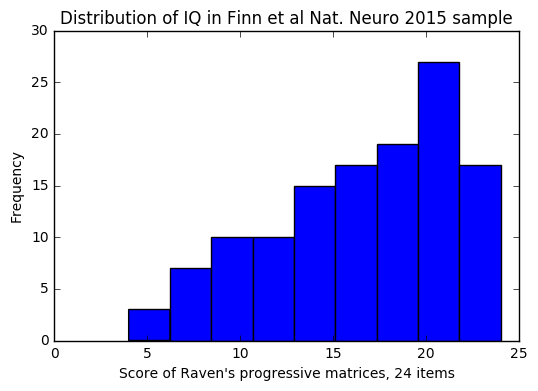

In [117]:
plot_hist(score, 'Distribution of IQ in Finn et al Nat. Neuro 2015 sample', \
          'Score of Raven\'s progressive matrices, 24 items')

### Exclusion of high-motion subjects
Further exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)

In [28]:
ResultsDir = op.join(DATADIR, 'Testing','Results')
if not op.isdir(ResultsDir): makedirs(ResultsDir)
#ResultsDir = op.join(DATADIR,'Results')
#if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, 'Finn')
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, parcellation)
if not op.isdir(ResultsDir): mkdir(ResultsDir)

PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
excludeSub = list()

for iSub in range(len(subjects)):
    subject = str(subjects[iSub])
    RelRMSMeanFile = op.join(buildpath(subject, thisRun+'_zz'), 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        print '{} {:.3f} {:.3f}'.format(subjects[iSub], RelRMSMean[iSub,0], RelRMSMean[iSub,1])
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print subjects[iSub], ': too much motion, exclude'
            excludeSub.append(iSub)
            continue
    
    if overwrite == 2:
        call('rm -rf '+op.join(buildpath(subject,fmriRun),'Step1*'),shell=True)
        if not isCifti:
            call('rm -rf '+op.join(buildpath(subject,fmriRun),'Volume*'),shell=True)
            call('rm -rf '+op.join(buildpath(subject,fmriRun),fmriRun+'_FinnPrepro.nii.gz'),shell=True)
        else:
            call('rm -rf '+op.join(buildpath(subject,fmriRun),'GrayOrd*'),shell=True)
            call('rm -rf '+op.join(buildpath(subject,fmriRun),fmriRun+'_FinnPrepro.dtseries.nii'),shell=True)
            
  
    
    for iPEdir in range(len(PEdirs)):
        PEdir=PEdirs[iPEdir]
        fmriRun = thisRun+'_'+PEdir
        if parcellation=='shenatal_neuroimage2013':
            fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+suffix+'.nii.gz')
            isCifti=0
        elif parcellation=='Glasser_Aseg_Suit':
            fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+'_Atlas'+suffix+'.dtseries.nii')
            isCifti=1
        else:
            print 'Wrong parcellation code'
            return
        if not op.isfile(fmriFile):
            print str(subjects[iSub]), 'missing', fmriFile, ', exclude'
            excludeSub.append(iSub)
            continue
        
        if not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+thisRun+'_'+PEdir+'.txt'))) \
        or overwrite:
            print 'load and preprocess'
            #Finn_loadandpreprocess(subject, fmriRun, parcellation, overwrite)
        else:
            print subject[iSub], ' : ', PEdir, 'results already computed; skipping'

indkeep = np.setdiff1d(range(len(subjects)),excludeSub, assume_unique=True)

NameError: name 'DATADIR' is not defined

In [21]:
boolvar = True
if boolvar == 2:
    print 'something'

In [353]:
len(indkeep)

117

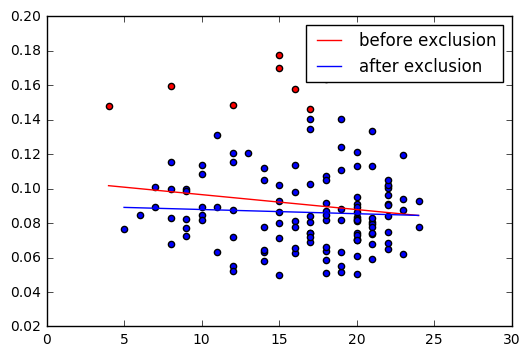

With all subjects: corr(IQ,motion) = -0.154 (p = 0.087)
After discarding high movers: corr(IQ,motion) = -0.056 (p = 0.552)


In [214]:
plt.scatter(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),c='b')
plt.scatter(score[excludeSub],np.mean(RelRMSMean[excludeSub,:],axis=1),c='r')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),1)
z2 = np.polyfit(score,np.mean(RelRMSMean,axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[indkeep])
fit2 = p2(score)
# get the coordinates for the fit curve
c1_x = [np.min(score[indkeep]),np.max(score[indkeep])]
c1_y = p1(c1_x)
c2_x = [np.min(score),np.max(score)]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1))
rho2,p2 = stats.pearsonr(score,np.mean(RelRMSMean,axis=1))                         
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)

### Correlation matrices

Correlate all pairs of node timecourses, resulting in 268x268 matrix of r-values

Apply Fisher transform to obtain 268x268 matrix of z-scores. The LR and RL runs are never concatenated. Rather, we run the above pipeline on each run separately and average the two resulting matrices of z-scores.

In [93]:
excludeSub

[8, 15, 34, 37, 51, 72, 104, 122]

In [307]:
len(indkeep)

117

In [101]:
# Whole Parcels
corrmats = np.zeros([268,268,len(indkeep)])
scores = np.zeros([len(indkeep)])
index = 0
for iSub in range(len(subjects)):
    if iSub not in excludeSub:
        PEdir=PEdirs[iPEdir] 
        tsFile_LR=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_LR.txt')
        tsFile_RL=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_RL.txt')
        ts_LR = np.loadtxt(tsFile_LR)
        ts_RL = np.loadtxt(tsFile_RL)
        # Fisher z transform of correlation coefficients
        corrMat_LR = np.arctanh(np.corrcoef(ts_LR,rowvar=0))
        corrMat_RL = np.arctanh(np.corrcoef(ts_RL,rowvar=0))
        np.fill_diagonal(corrMat_LR,1)
        np.fill_diagonal(corrMat_RL,1)
        corrmats[:,:,index] = (corrMat_LR + corrMat_RL)/2
        scores[index] = score[iSub]
        
results = {}
results[outMat] = corrmats
results[outScore] = scores
sio.savemat(op.join(ResultsDir,'{}_HCP_{}.mat'.format(thisRun,release)),results)

# GM Parcels        
#index = 0
#for iSub in range(len(subjects)):
#    if iSub not in excludeSub:
#        PEdir=PEdirs[iPEdir] 
#        tsFile_LR=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_LR_GM.txt')
#        tsFile_RL=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_RL_GM.txt')
#        ts_LR = np.loadtxt(tsFile_LR)
#        ts_RL = np.loadtxt(tsFile_RL)
#        # Fisher z transform of correlation coefficients
#        corrMat_LR = np.arctanh(np.corrcoef(ts_LR,rowvar=0))
#        corrMat_RL = np.arctanh(np.corrcoef(ts_RL,rowvar=0))
#        np.fill_diagonal(corrMat_LR,1)
#        np.fill_diagonal(corrMat_RL,1)
#        corrmats[:,:,index] = (corrMat_LR + corrMat_RL)/2
#        scores[index] = score[iSub]
        
#results = {}
#results[outMat] = corrmats
#results[outScore] = scores
#sio.savemat(op.join(ResultsDir,'{}_HCP_{}_GM.mat'.format(thisRun,release)),results)      

### Behavioral prediction

In [53]:
toLoad = '/home/paola/Downloads/rfMRI_REST1_HCP_Q2'
data = sio.loadmat(toLoad)

## INPUTS
all_mats = data['rest_1_mat']
all_behav = data['PMAT24_A_CR']

# threshold for feature selection
thresh = 0.01

no_sub = all_mats.shape[2]
no_node = all_mats.shape[0]

behav_pred_pos = np.zeros([no_sub,1])
behav_pred_neg = np.zeros([no_sub,1])

In [75]:
all_mats.shape

(268, 268, 115)

In [71]:
loo = cross_validation.LeaveOneOut(no_sub)
lr = linear_model.LinearRegression()
predictions_pos = np.zeros([no_sub,1])
predictions_neg = np.zeros([no_sub,1])

for train_index, test_index in loo:
    # leave out subject from matrices and behaviour
    train_mats = all_mats[:,:,train_index]
    train_vcts = np.reshape(train_mats, [-1,train_mats.shape[2]])
    train_behav = all_behav[train_index]
    vcts_len = train_vcts.shape[0]
    # correlate all edges with behavior
    pears = [stats.pearsonr(train_vcts[i,:],np.squeeze(train_behav)) 
             for i in range(vcts_len)]
    # set threshold and define masks
    idx_filtered_pos = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]>0])
    idx_filtered_neg = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]<0])
    filtered_pos = train_vcts[idx_filtered_pos,:]
    filtered_neg = train_vcts[idx_filtered_neg,:]
    # get sum of all edges in TRAIN subs (divide by 2 to control
    # for the fact that matrices are symmetric)
    train_sumpos = filtered_pos.sum(axis=0)/2 
    train_sumneg = filtered_neg.sum(axis=0)/2
    # build model on TRAIN subs
    z_pos = np.polyfit(train_sumpos,np.squeeze(train_behav),1)
    p = np.poly1d(z_pos)
    fit_pos = p(train_sumpos)
    z_neg = np.polyfit(train_sumneg,np.squeeze(train_behav),1)
    p = np.poly1d(z_neg)
    fit_neg = p(train_sumneg)
    # run model on TEST sub
    test_mats = all_mats[:,:,test_index]
    test_vec = np.reshape(test_mats, [-1,test_mats.shape[2]])
    test_sumpos = test_vec[idx_filtered_pos].sum()/2
    test_sumneg = test_vec[idx_filtered_neg].sum()/2
    behav_pred_pos[test_index] = z_pos[0] * test_sumpos + z_pos[1]
    behav_pred_neg[test_index] = z_neg[0] * test_sumneg + z_neg[1]
    lr_pos = lr.fit(train_sumpos.reshape(-1,1),train_behav)
    predictions_pos[test_index] = lr_pos.predict(test_sumpos)
    lr_neg = lr.fit(train_sumneg.reshape(-1,1),train_behav)
    predictions_neg[test_index] = lr_neg.predict(test_sumneg) 

In [76]:
# compare predicted and observed score
R_pos,P_pos = stats.pearsonr(np.squeeze(behav_pred_pos),np.squeeze(all_behav))
R_neg,P_neg = stats.pearsonr(np.squeeze(behav_pred_neg),np.squeeze(all_behav)) 
R_pos2,P_pos2 = stats.pearsonr(np.squeeze(predictions_pos),np.squeeze(all_behav))
R_neg2,P_neg2 = stats.pearsonr(np.squeeze(predictions_neg),np.squeeze(all_behav)) 

In [303]:
all_behav.shape

(115, 1)

In [ ]:
loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[test_index,idx_filtered_pos].sum()
        str_neg_test = edges[test_index,idx_filtered_neg].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[i] = lr_pos.predict(str_pos_test)
        lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
        predictions_neg[i] = lr_neg.predict(str_neg_test) 
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)

(0.21525729414666023, 0.2152572941466605)


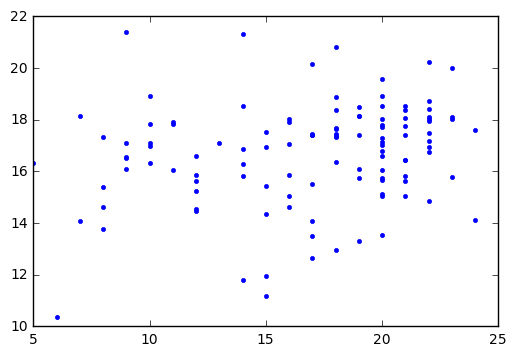

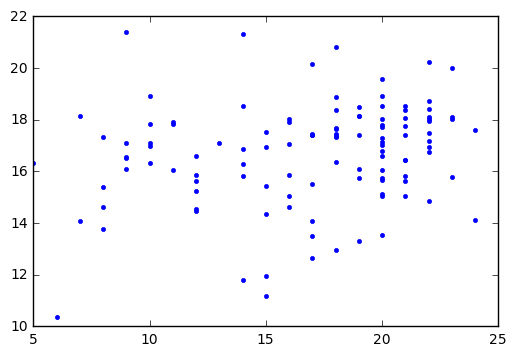

In [77]:
plt.figure()
plt.plot(all_behav,behav_pred_pos,'b.')
plt.figure()
plt.plot(all_behav,predictions_pos,'b.')
print(R_pos, R_pos2)

0.178047265341


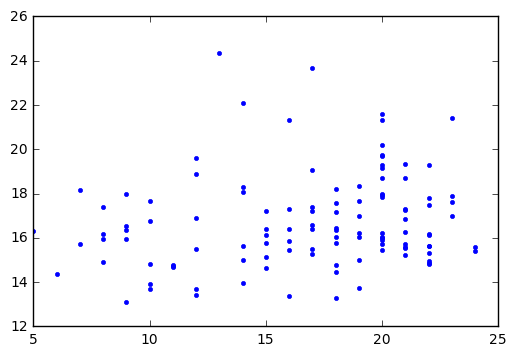

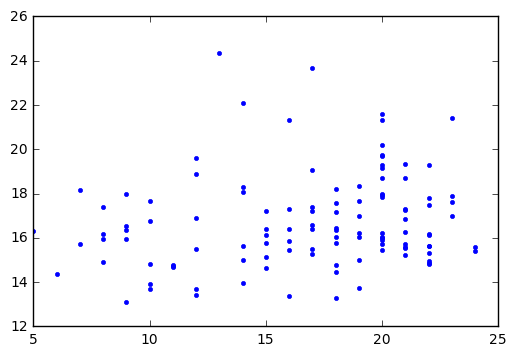

In [305]:
plt.figure()
plt.plot(all_behav,behav_pred_pos,'b.')
plt.figure()
plt.plot(all_behav,predictions_pos,'b.')
print(R_pos)